In [23]:
import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import matplotlib.pyplot as pp
from scipy.signal import find_peaks
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
import matplotlib as mpl
import math
from operator import add
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pims
import trackpy as tp
from skimage.feature import peak_local_max
from scipy.ndimage.morphology import distance_transform_edt as edt
from IPython.display import clear_output
import timeit
import cv2

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(20, 20))
mpl.rc('image', cmap='gray')
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline


def collect(x, y, sigma):
    neighborhood = []
    X = int(sigma)
    for i in range(-X, X + 1):
        Y = int(pow(sigma * sigma - i * i, 1/2))
        for j in range(-Y, Y + 1):
            neighborhood.append((x + i, y + j))
    return neighborhood

def rtpairs(r, n):
    for i in range(len(r)):
        for j in range(n[i]):    
            yield r[i], j*(2 * np.pi / n[i])

#Image Loading
str1 = 'images/'
date = '25_03_19'
name = 'Cd_dots_osmotic_shock'
other = '/non_normalised/stage2/'# non_normalised for dots, dyeChannel for dyes
extension = '*.tif'
path = str1+date+'/'+name+other+extension

frames = pims.ImageSequence(path, as_grey=True)


0


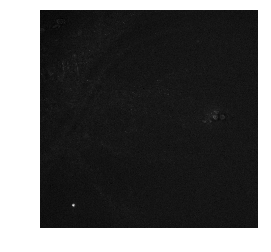

In [21]:
total_frames = len(frames)

image1= np.int64(frames[0])
for frameNum in range(1, total_frames-1):
    image1 = np.subtract(image1,np.int64(frames[frameNum]))
    
#im = edt(image1)

roi_size = 11

coordinates = peak_local_max(image1, min_distance=roi_size, exclude_border=True,threshold_rel = 0.1)

good_coordinates = coordinates#[np.array([0,10,11,12,13,14,15,17,20,24,28,36,37,38])]

total_particles = len(good_coordinates)
particle_index = np.linspace(0,total_particles-1,total_particles,dtype='int')
particle_coords = [0] * total_frames
particle_roi_dict = dict(zip(particle_index, particle_coords))

fig1 = pp.figure()
pp.imshow(im, cmap=pp.cm.gray)
pp.imshow(frames[1], cmap=pp.cm.gray)
pp.autoscale(False)
pp.axis('off')

for index, shift in enumerate(good_coordinates):
    current_coords = [0,0]
    centre_x = shift[1]
    centre_y = shift[0] 
    particle_roi_dict[index] = collect(int(centre_x), int(centre_y), roi_size)
    #####Plotting
    #for r, t in rtpairs([0, round(roi_size)], [1, 10, 20, 30, 40, 50, 60]):
     #   x = (r * np.cos(t))+ int(centre_x)
      #  y = (r * np.sin(t))+ int(centre_y)
       # pp.plot(x,y, 'r,')
    
print(len(good_coordinates))       
pp.plot(good_coordinates[:,1],good_coordinates[:,0],'r,')

#z=0
#for xy in zip(good_coordinates[:,1], good_coordinates[:,0]):                                      
#    pp.annotate(str(z), xy=xy,color='white',xytext=xy) 
#    z = z+1

#fig1.savefig('example.png', dpi = 100)

pp.show()

In [4]:
noParticles = len(particle_roi_dict)

frame_index = np.linspace(0,total_frames-1,total_frames,dtype='int')
frame_intensity = [0] * total_frames
overall_dict = dict(zip(frame_index, frame_intensity))

#subsection = frames[:5]

start = timeit.default_timer()

#for key0, value0 in enumerate(particle_roi_dict):  #Key0: particle number
#    clear_output(wait=True)    
#    current_particle_intensity = 0
#    particle_dict = dict()
#    for key1, value1 in enumerate(frames): #key1: frame number, value1: frame info
#        #current_particle_intensity = 0
#        #for key2, value2 in enumerate(particle_roi_dict[key0]):  #key2: particle coord index, value2: particle roi coord
#        #    current_particle_intensity = current_particle_intensity + value1[value2[0]][value2[1]] #intensity for one ROI in one frame
#        #particle_dict[key1] = current_particle_intensity
#        a = np.asarray(particle_roi_dict[key0])
#        particle_dict[key1] = np.sum(value1[a[:,0],a[:,1]])
#    overall_dict[key0] = particle_dict
    
for key1, value1 in enumerate(frames): #key1: frame number, value1: frame info
    clear_output(wait=True)
    current_particle_intensity = 0
    particle_dict = dict()
    for key0, value0 in enumerate(particle_roi_dict): #Key0: particle number
        a = np.asarray(particle_roi_dict[key0])
        particle_dict[key0] = np.sum(value1[a[:,0],a[:,1]])
    overall_dict[key1] = particle_dict
        
    stop = timeit.default_timer()
    if (key1/len(frames)*100) <5 :
        expected_time = "Calculating..."
    else:
        time_perc = timeit.default_timer()
        expected_time = np.round(((time_perc-start)/(key1/len(frames)))/60,2)
    print("Current progress:",np.round(key1/len(frames)*100,2),"%")
    print("Current run time:",np.round((stop-start)/60,2),"minutes")
    print("Expected run time:",expected_time,"minutes")
    
new_overall_dict = dict()
for key0 in range(0,len(overall_dict[0])): #key1: particle number
    new_current_particle = dict()
    for key1 in range(0,len(overall_dict)): #key1: frame number
        new_current_particle[key1]=overall_dict[key1][key0]
    new_overall_dict[key0] = new_current_particle
    

Current progress: 98.28 %
Current run time: 0.05 minutes
Expected run time: 0.05 minutes


In [5]:
for particle in range(0, noParticles): 
    fig = pp.figure()
    ax = pp.axes()
    ax.plot(new_overall_dict[particle].keys(), new_overall_dict[particle].values());
    fig.savefig(str(particle)+'.png', bbox_inches='tight')
    pp.close('all')

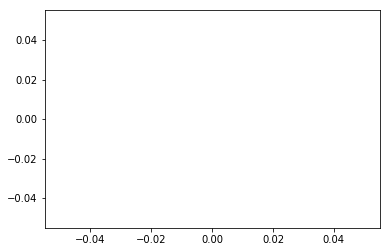

In [6]:
particle = 0
pp.plot(overall_dict[particle].keys(), overall_dict[particle].values());

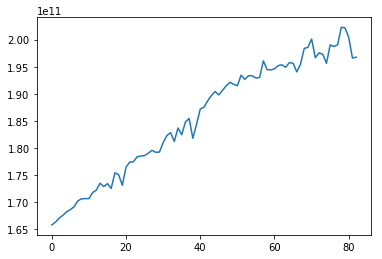

In [314]:
#Sum all of these to plot a total curve.

value_range = np.array(new_overall_dict[0].values())
for ind in range(1, noParticles):
    value_range = np.sum([value_range,np.array(new_overall_dict[0].values())],axis=0)

x_frame = np.linspace(0, total_frames-1, num=total_frames)

fig = pp.figure()
ax = pp.axes()
ax.plot(x_frame, value_range);




In [308]:
np.sum([np.array(new_overall_dict[0].values()),np.array(new_overall_dict[0].values())],axis=0)

array([18854908, 18953082, 18927980, 19062728, 19109246, 18907990,
       18973424, 19410210, 19780580, 19617190, 19094280, 19748042,
       19707990, 20002182, 19814472, 19978470, 19036904, 20938452,
       20247424, 19242942, 21339148, 21517580, 21489428, 21995052,
       21456234, 21447820, 21642060, 21582424, 21770354, 20483676,
       22161354, 22428862, 22877530, 21172864, 22860376, 21566370,
       23308488, 23762390, 20312104, 22537438, 24196850, 23859706,
       24581306, 24659508, 25152714, 24712040, 24785804, 25703506,
       25708324, 25145184, 24945236, 26499716, 25664120, 25993560,
       25960308, 25187900, 25761906, 27031054, 25636716, 25883660,
       25864820, 26108654, 25769248, 25963248, 26015380, 26375238,
       24572118, 25648572, 27933998, 28296486, 29291836, 26159146,
       27293882, 26616194, 25232830, 27738032, 27734284, 27918998,
       29784800, 29884196, 28539292, 25593096, 25463890], dtype=uint64)

In [307]:
array1

array([ 9427454,  9476541,  9463990,  9531364,  9554623,  9453995,
        9486712,  9705105,  9890290,  9808595,  9547140,  9874021,
        9853995, 10001091,  9907236,  9989235,  9518452, 10469226,
       10123712,  9621471, 10669574, 10758790, 10744714, 10997526,
       10728117, 10723910, 10821030, 10791212, 10885177, 10241838,
       11080677, 11214431, 11438765, 10586432, 11430188, 10783185,
       11654244, 11881195, 10156052, 11268719, 12098425, 11929853,
       12290653, 12329754, 12576357, 12356020, 12392902, 12851753,
       12854162, 12572592, 12472618, 13249858, 12832060, 12996780,
       12980154, 12593950, 12880953, 13515527, 12818358, 12941830,
       12932410, 13054327, 12884624, 12981624, 13007690, 13187619,
       12286059, 12824286, 13966999, 14148243, 14645918, 13079573,
       13646941, 13308097, 12616415, 13869016, 13867142, 13959499,
       14892400, 14942098, 14269646, 12796548, 12731945], dtype=uint64)